In [1]:
import json
from torch.utils.data import Dataset
#from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import torch

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
class JSONLDataset(Dataset):
    def __init__(self, file_path, ul2=False,max_text_len = 100, max_block_size = 100):
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token_id = 50256
        self.tokenizer.add_tokens(['[R]', '[S]', '[X]'])
        self.tokenizer.add_tokens([f'sentinel_token_{i}' for i in range(500)])
        self.tokenizer.add_tokens([f'sentinel_token_s_{i}' for i in range(500)])
        
        self.path = file_path
        self.max_block_size = max_block_size
        self.max_length = max_text_len
        self.vocab_size = len(self.tokenizer)
        x = []
        y = []
        f = open(file_path,'r')
        lines = f.readlines()

        if ul2 == False:
            for line in lines:
                item = json.loads(line)['text'][:max_text_len]
                
                item = self.tokenizer(item, padding='max_length',max_length=max_text_len, truncation=True,return_tensors='pt')["input_ids"][0]
                if len(item) > self.max_length:
                    continue
                x.append(item[:-1])
                y.append(item[1:])

            self.x = x
            self.y = y
        else:
            for line in lines:
                item = json.loads(line)['text'][:max_text_len]
                denoise_type = np.random.choice(["[R]","[S]","[X]"],p=[0.25,0.5,0.25])
                denoise_type_token = self.tokenizer(denoise_type)['input_ids'][0]
                item = self.tokenizer(item, truncation=True,return_tensors='pt', add_special_tokens=True)["input_ids"][0].long()#[:100]
                if len(item) >= self.max_length:
                    continue
                
                target = torch.cat((item, torch.tensor([self.tokenizer.eos_token_id] * (self.max_length-1 - item.shape[0])).long()))
                y.append(target)
                item = torch.cat((torch.tensor([denoise_type_token]).long(), item[:-1]))

                if denoise_type == "[R]":
                    out = self.r_denoising(item)
                    if out != None:
                        inputs = out
                elif denoise_type == "[S]":
                    inputs = self.s_denoising(item)
                else:
                    inputs = self.x_denoising(item)
                x.append(inputs)

            self.x = x
            self.y = y
            
    def r_denoising(self, inputs, corruption_rate=0.15):
        # initializing
        skip_steps = 0
        tokens_used = 0
        check = 0
        sequence_length = inputs.shape[0]
        
        # loop through the sequence
        for i in range(1, sequence_length-5):
            # avoid the span
            if skip_steps > 0:
                skip_steps -= 1
                continue
            # check if want to span
            if np.random.random() < corruption_rate:
                check += 1
                # Randomly choose a span length for corruption
                span_length = np.random.choice([2,3,4,5])
                
                # get sentinel tokens
                #sentinel_token = self.tokenizer(f"sentinel_token_{tokens_used}")['input_ids'][0]
                sentinel_token = torch.tensor([self.tokenizer(f'sentinel_token_{tokens_used+i}')['input_ids'][0] for i in range(span_length)]).long()
                tokens_used += span_length
                # add sentinel token
                inputs = torch.cat((inputs[:i], sentinel_token, inputs[i + span_length:]))  # Mask the corrupted span in ids
                steps_to_skip = span_length
        # padding
        inputs = torch.cat((inputs, torch.tensor([self.tokenizer.eos_token_id] * (self.max_length-1 - inputs.shape[0])).long()))
        return inputs
    
    def s_denoising(self, inputs):
        # get the length
        sequence_length = inputs.shape[0]
        # get the random denoising start point
        span_start = np.random.choice(np.arange(0,sequence_length))
        # get a list of sential tokens
        new_sentinel_tokens = torch.tensor([self.tokenizer(f'sentinel_token_s_{i}')['input_ids'][0] for i in range(sequence_length-span_start)]).long()
        # add the noise
        inputs = torch.cat((inputs[:span_start], new_sentinel_tokens))
        inputs = torch.cat((inputs, torch.tensor([self.tokenizer.eos_token_id] * (self.max_length-1 - inputs.shape[0])).long()))
        return inputs
    
    def x_denoising(self, inputs):
        # use R denoising function but increase the corruption rate
        return self.r_denoising(inputs, corruption_rate=0.5)
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.max_block_size * 2 -1
                    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x,y


In [4]:
dataset1 = JSONLDataset("proj2_data.jsonl")
dataset2 = JSONLDataset("proj2_data.jsonl",ul2=True)

In [7]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = dataset1.get_vocab_size()
model_config.block_size = dataset1.get_block_size()
#model_config.checkpoint = "check/model_checkpoint_iter_50.pth"
model_config.checkpoint = None
model1 = GPT(model_config)

number of parameters: 2.55M


In [10]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 300
train_config.num_workers = 0
trainer1 = Trainer(train_config, model1, dataset1)
#trainer2 = Trainer(train_config, model2, dataset2)

running on device cpu


In [13]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = dataset1.get_vocab_size()
model_config.block_size = dataset1.get_block_size()
model_config.checkpoint = None
model1 = GPT(model_config)

# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 101
train_config.num_workers = 0
trainer1 = Trainer(train_config, model1, dataset1)




loss = []
def batch_end_callback(trainer):
    if trainer.iter_num % 50 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        loss.append(trainer.loss.item())
trainer1.set_callback('on_batch_end', batch_end_callback)

trainer1.run()

number of parameters: 2.55M
running on device cpu
iter_dt 0.00ms; iter 0: train loss 10.87525
iter_dt 2601.69ms; iter 50: train loss 8.26187
iter_dt 2648.13ms; iter 100: train loss 6.20617


In [15]:
# create a GPT instance
#checkpoint_iter = [50,100,150,200,250,300]
checkpoint_iter = [50,100]
for i in checkpoint_iter:
    model_config = GPT.get_default_config()
    model_config.model_type = 'gpt-nano'
    model_config.vocab_size = dataset2.get_vocab_size()
    model_config.block_size = dataset2.get_block_size()
    model_config.checkpoint = f"model_checkpoint_iter_{i}.pth"
    model2 = GPT(model_config)

    train_config = Trainer.get_default_config()
    train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
    train_config.max_iters = 11
    train_config.num_workers = 0
    train_config.ul2 = True
    train_config.ul2_checkpoint = i
    trainer2 = Trainer(train_config, model2, dataset2)
    #trainer2.run()


    loss_ul2 = []
    def batch_end_callback(trainer):
        if trainer.iter_num % 10 == 0:
            print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
            loss_ul2.append(trainer.loss.item())
    trainer2.set_callback('on_batch_end', batch_end_callback)

    trainer2.run()


number of parameters: 2.55M
running on device cpu
iter_dt 0.00ms; iter 0: train loss 10.88029
iter_dt 2316.77ms; iter 10: train loss 10.00289
number of parameters: 2.55M
running on device cpu
iter_dt 0.00ms; iter 0: train loss 10.91503
iter_dt 2342.89ms; iter 10: train loss 10.15583


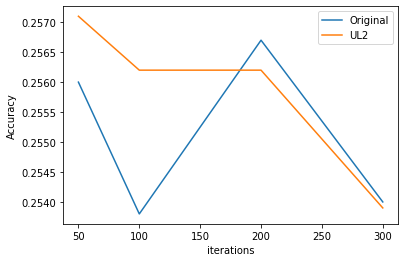

In [18]:
orignal = [0.2560,0.2538, 0.2567, 0.2540]
ul2 = [0.2571,0.2562, 0.2562, 0.2539]
x = [50,100,200,300]
plt.plot(x,orignal,label="Original")
plt.plot(x,ul2,label="UL2")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("acc_ul2")